# 🧬 Análise Comparativa: Algoritmos Tradicionais vs MLP (Redes Neurais)

## Predição de Diabetes com Machine Learning e Deep Learning

**Dataset:** Dataset_of_Diabetes.csv (1000 registros, 14 atributos)  
**Objetivo:** Classificar pacientes em 3 categorias: Normal (N), Pré-diabético (P), Diabético (Y)  
**Metodologia:** Comparação de 6 algoritmos tradicionais + 5 arquiteturas de Redes Neurais MLP

---

### 📊 Algoritmos Testados:

**Algoritmos Tradicionais:**
1. K-Nearest Neighbors (K-NN)
2. Naive Bayes
3. Support Vector Machine (SVM)
4. Decision Tree
5. Random Forest
6. Logistic Regression

**Arquiteturas MLP (Redes Neurais):**
1. MLP Simples (1 camada: 50 neurônios)
2. MLP Média (2 camadas: 100→50)
3. MLP Profunda (3 camadas: 150→100→50)
4. MLP Grande (2 camadas largas: 200→100)
5. MLP Otimizada (Grid Search)

**Total:** 11 modelos comparados!

---
## 📦 1. Imports e Configuração

In [70]:
# Imports básicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sqlalchemy import create_engine
import io
from datetime import datetime

# Machine Learning - Algoritmos Tradicionais
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report,
    precision_recall_fscore_support
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Deep Learning - Redes Neurais
from sklearn.neural_network import MLPClassifier

# MLflow e MinIO
import mlflow
import mlflow.sklearn
from minio import Minio
from minio.error import S3Error

print("✓ Todos os pacotes importados com sucesso!")

✓ Todos os pacotes importados com sucesso!


In [71]:
# Configuração do ambiente
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Diretório de saída
OUTPUT_DIR = "./outputs"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"✓ Diretório criado: {OUTPUT_DIR}")
else:
    print(f"✓ Diretório já existe: {OUTPUT_DIR}")

print("\n✓ Ambiente configurado!")

✓ Diretório já existe: ./outputs

✓ Ambiente configurado!


---
## 🔌 2. Configuração MinIO e MLflow

In [72]:
# Configuração MinIO
MINIO_ENDPOINT = "minio:9000"
MINIO_ACCESS_KEY = "minioadmin"
MINIO_SECRET_KEY = "minioadmin"
MINIO_BUCKET = "diabetes-analysis"

try:
    minio_client = Minio(
        MINIO_ENDPOINT,
        access_key=MINIO_ACCESS_KEY,
        secret_key=MINIO_SECRET_KEY,
        secure=False
    )
    
    # Criar bucket se não existir
    if not minio_client.bucket_exists(MINIO_BUCKET):
        minio_client.make_bucket(MINIO_BUCKET)
        print(f"✓ Bucket '{MINIO_BUCKET}' criado no MinIO")
    else:
        print(f"✓ Conectado ao bucket '{MINIO_BUCKET}' no MinIO")
    
    MINIO_CONNECTED = True
except Exception as e:
    print(f"⚠️  Erro ao conectar com MinIO: {e}")
    print("   Continuando sem MinIO...")
    MINIO_CONNECTED = False

✓ Conectado ao bucket 'diabetes-analysis' no MinIO


In [73]:
# Configuração MLflow
MLFLOW_TRACKING_URI = "http://mlflow:5000"
EXPERIMENT_NAME = "Diabetes-Analysis-Traditional-vs-MLP"

try:
    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
    mlflow.set_experiment(EXPERIMENT_NAME)
    print(f"✓ MLflow configurado")
    print(f"  • Tracking URI: {MLFLOW_TRACKING_URI}")
    print(f"  • Experiment: {EXPERIMENT_NAME}")
    MLFLOW_CONNECTED = True
except Exception as e:
    print(f"⚠️  Erro ao configurar MLflow: {e}")
    print("   Continuando sem MLflow...")
    MLFLOW_CONNECTED = False

✓ MLflow configurado
  • Tracking URI: http://mlflow:5000
  • Experiment: Diabetes-Analysis-Traditional-vs-MLP


---
## 📂 3. Carregamento dos Dados

### Opção 1: PostgreSQL (se disponível)
### Opção 2: CSV (fallback)

In [74]:
# Tentar carregar do PostgreSQL
POSTGRES_URL = "postgresql://user:password@db:5432/diabetes_db"
path = 'Dataset_of_Diabetes.csv'

try:
    engine = create_engine(POSTGRES_URL)
    raw_conn = engine.raw_connection()
    
    df = pd.read_sql("SELECT * FROM diabetes_tb", raw_conn)
    df.columns = [c.upper() for c in df.columns]
    
    print(f"✓ Dados carregados do PostgreSQL: {df.shape[0]} registros")
    
    raw_conn.close()
    DATA_SOURCE = "PostgreSQL"
    
except Exception as e:
    print(f"⚠️  PostgreSQL não disponível: {e}")
    print("   Tentando carregar do CSV...")
    
    # Fallback para CSV
    try:
        df = pd.read_csv('Dataset_of_Diabetes.csv')
        print(f"✓ Dados carregados do CSV: {df.shape[0]} registros")
        DATA_SOURCE = "CSV"
    except:
        print("❌ Erro: Arquivo CSV não encontrado!")
        print("   Coloque o arquivo 'Dataset_of_Diabetes.csv' no mesmo diretório do notebook.")
        raise FileNotFoundError("Dataset não encontrado")

# Mostrar informações do dataset
print(f"\n📊 Informações do Dataset:")
print(f"  • Fonte: {DATA_SOURCE}")
print(f"  • Dimensões: {df.shape[0]} registros × {df.shape[1]} atributos")
print(f"  • Colunas: {df.columns.tolist()}")

# Mostrar primeiras linhas
print(f"\n📋 Primeiras 5 linhas:")
display(df.head())

✓ Dados carregados do PostgreSQL: 1000 registros

📊 Informações do Dataset:
  • Fonte: PostgreSQL
  • Dimensões: 1000 registros × 14 atributos
  • Colunas: ['ID', 'NO_PATION', 'GENDER', 'AGE', 'UREA', 'CR', 'HBA1C', 'CHOL', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI', 'CLASS']

📋 Primeiras 5 linhas:


,ID,NO_PATION,GENDER,AGE,UREA,CR,HBA1C,CHOL,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


---
## 🔍 4. Análise Exploratória Inicial

In [75]:
# Informações básicas
print("📊 INFORMAÇÕES DO DATASET:\n")
print(df.info())

print("\n" + "="*80)
print("📊 ESTATÍSTICAS DESCRITIVAS:\n")
display(df.describe())

# Distribuição das classes
print("\n" + "="*80)
print("📊 DISTRIBUIÇÃO DAS CLASSES:\n")
df['CLASS'] = df['CLASS'].str.strip()
class_dist = df['CLASS'].value_counts()
print(class_dist)
print()
for classe, count in class_dist.items():
    percentage = (count / len(df)) * 100
    print(f"  • Classe '{classe}': {count} registros ({percentage:.1f}%)")

📊 INFORMAÇÕES DO DATASET:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   NO_PATION  1000 non-null   int64  
 2   GENDER     1000 non-null   object 
 3   AGE        1000 non-null   int64  
 4   UREA       1000 non-null   float64
 5   CR         1000 non-null   int64  
 6   HBA1C      1000 non-null   float64
 7   CHOL       1000 non-null   float64
 8   TG         1000 non-null   float64
 9   HDL        1000 non-null   float64
 10  LDL        1000 non-null   float64
 11  VLDL       1000 non-null   float64
 12  BMI        1000 non-null   float64
 13  CLASS      1000 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 109.5+ KB
None

📊 ESTATÍSTICAS DESCRITIVAS:



,ID,NO_PATION,AGE,UREA,CR,HBA1C,CHOL,TG,HDL,LDL,VLDL,BMI
count,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,340.500000,2.705514e+05,53.528000,5.124743,68.943000,8.281160,4.862820,2.349610,1.204750,2.609790,1.854700,29.578020
std,240.397673,3.380758e+06,8.799241,2.935165,59.984747,2.534003,1.301738,1.401176,0.660414,1.115102,3.663599,4.962388
min,1.000000,1.230000e+02,20.000000,0.500000,6.000000,0.900000,0.000000,0.300000,0.200000,0.300000,0.100000,19.000000
25%,125.750000,2.406375e+04,51.000000,3.700000,48.000000,6.500000,4.000000,1.500000,0.900000,1.800000,0.700000,26.000000
50%,300.500000,3.439550e+04,55.000000,4.600000,60.000000,8.000000,4.800000,2.000000,1.100000,2.500000,0.900000,30.000000
75%,550.250000,4.538425e+04,59.000000,5.700000,73.000000,10.200000,5.600000,2.900000,1.300000,3.300000,1.500000,33.000000
max,800.000000,7.543566e+07,79.000000,38.900000,800.000000,16.000000,10.300000,13.800000,9.900000,9.900000,35.000000,47.750000



📊 DISTRIBUIÇÃO DAS CLASSES:

CLASS
Y    844
N    103
P     53
Name: count, dtype: int64

  • Classe 'Y': 844 registros (84.4%)
  • Classe 'N': 103 registros (10.3%)
  • Classe 'P': 53 registros (5.3%)


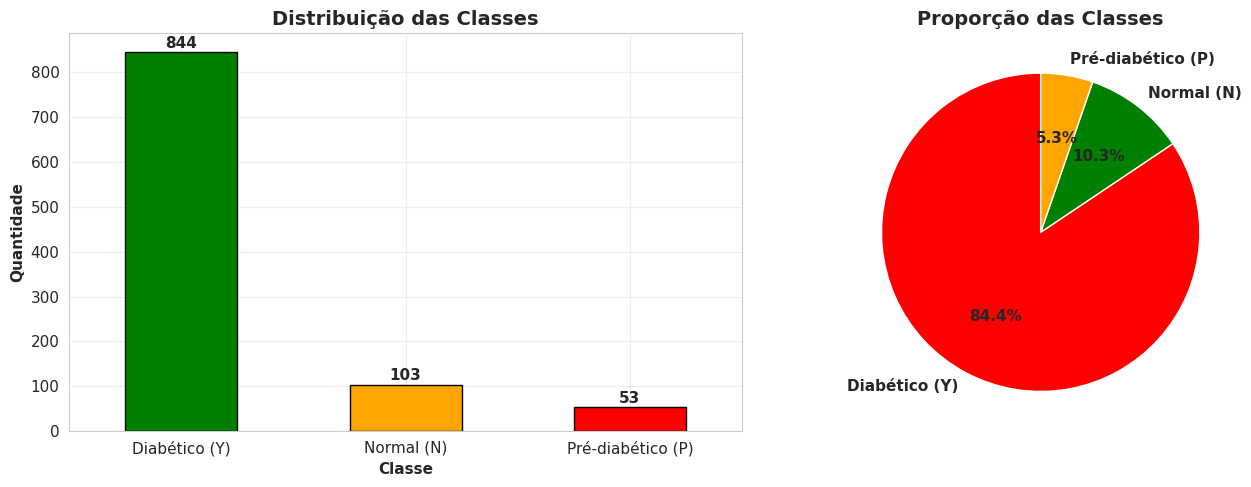

✓ Gráfico salvo: 00_distribuicao_classes.png


In [76]:
# Visualização da distribuição das classes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
class_dist.plot(kind='bar', ax=ax1, color=['green', 'orange', 'red'], edgecolor='black')
ax1.set_title('Distribuição das Classes', fontsize=14, fontweight='bold')
ax1.set_xlabel('Classe', fontweight='bold')
ax1.set_ylabel('Quantidade', fontweight='bold')
ax1.set_xticklabels(['Diabético (Y)', 'Normal (N)', 'Pré-diabético (P)'], rotation=0)
ax1.grid(True, alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(class_dist.values):
    ax1.text(i, v + 10, str(v), ha='center', fontweight='bold')

# Gráfico de pizza
colors = ['red', 'green', 'orange']
ax2.pie(class_dist.values, labels=['Diabético (Y)', 'Normal (N)', 'Pré-diabético (P)'], 
        autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontweight': 'bold'})
ax2.set_title('Proporção das Classes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/00_distribuicao_classes.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico salvo: 00_distribuicao_classes.png")

---
## 🧹 5. Pré-processamento dos Dados

In [77]:
print("🧹 INICIANDO PRÉ-PROCESSAMENTO DOS DADOS...\n")

# Identificar valores zeros (biologicamente impossíveis)
cols_to_clean = ['UREA', 'CR', 'HBA1C', 'CHOL', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI']

print("📊 Valores zeros encontrados (antes da limpeza):")
for col in cols_to_clean:
    zero_count = (df[col] == 0).sum()
    if zero_count > 0:
        percentage = (zero_count / len(df)) * 100
        print(f"  • {col}: {zero_count} valores ({percentage:.2f}%)")

# Substituir zeros por NaN
df[cols_to_clean] = df[cols_to_clean].replace(0, np.nan)

# Estratégia de imputação
print("\n⚙️  Aplicando estratégia de imputação:")
print("  • Mean: UREA, CR, CHOL, HDL (distribuições aprox. normais)")
print("  • Median: HBA1C, TG, LDL, VLDL, BMI (distribuições assimétricas)")

mean_cols = ['UREA', 'CR', 'CHOL', 'HDL']
for col in mean_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mean(), inplace=True)

median_cols = ['HBA1C', 'TG', 'LDL', 'VLDL', 'BMI']
for col in median_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

print("\n✓ Valores ausentes tratados com sucesso!")
print(f"  • Total de NaN após tratamento: {df.isnull().sum().sum()}")

🧹 INICIANDO PRÉ-PROCESSAMENTO DOS DADOS...

📊 Valores zeros encontrados (antes da limpeza):
  • CHOL: 1 valores (0.10%)

⚙️  Aplicando estratégia de imputação:
  • Mean: UREA, CR, CHOL, HDL (distribuições aprox. normais)
  • Median: HBA1C, TG, LDL, VLDL, BMI (distribuições assimétricas)

✓ Valores ausentes tratados com sucesso!
  • Total de NaN após tratamento: 0


In [78]:
# Preparar dados para modelagem
print("\n📦 PREPARANDO DADOS PARA MODELAGEM...\n")

# Remover colunas irrelevantes
df_model = df.drop(['ID', 'NO_PATION'], axis=1)
print(f"✓ Colunas ID e NO_PATION removidas")

# Encoding de Gender
label_encoder = LabelEncoder()
df_model['GENDER'] = label_encoder.fit_transform(df_model['GENDER'])
print(f"✓ GENDER codificado (F=0, M=1)")

# Separar features e target
X = df_model.drop('CLASS', axis=1)
y = df_model['CLASS']

print(f"\n📊 Dimensões finais:")
print(f"  • Features (X): {X.shape}")
print(f"  • Target (y): {y.shape}")
print(f"  • Features: {X.columns.tolist()}")


📦 PREPARANDO DADOS PARA MODELAGEM...

✓ Colunas ID e NO_PATION removidas
✓ GENDER codificado (F=0, M=1)

📊 Dimensões finais:
  • Features (X): (1000, 11)
  • Target (y): (1000,)
  • Features: ['GENDER', 'AGE', 'UREA', 'CR', 'HBA1C', 'CHOL', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI']


In [79]:
# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✂️  DIVISÃO DOS DADOS (80/20):\n")
print(f"  • Treino: {X_train.shape[0]} registros")
print(f"  • Teste: {X_test.shape[0]} registros")
print(f"\n  • Distribuição treino: {y_train.value_counts().to_dict()}")
print(f"  • Distribuição teste: {y_test.value_counts().to_dict()}")

✂️  DIVISÃO DOS DADOS (80/20):

  • Treino: 800 registros
  • Teste: 200 registros

  • Distribuição treino: {'Y': 675, 'N': 82, 'P': 43}
  • Distribuição teste: {'Y': 169, 'N': 21, 'P': 10}


In [80]:
# Normalização (ESSENCIAL para MLP, KNN e SVM!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("⚖️  NORMALIZAÇÃO CONCLUÍDA (StandardScaler)\n")
print(f"  • Mean ≈ 0, Std ≈ 1 para todas as features")
print(f"\n✓ Dados prontos para treinamento!")

⚖️  NORMALIZAÇÃO CONCLUÍDA (StandardScaler)

  • Mean ≈ 0, Std ≈ 1 para todas as features

✓ Dados prontos para treinamento!


---
## 🤖 6. Treinamento - Algoritmos Tradicionais

Testando 6 algoritmos clássicos de Machine Learning

In [81]:
print("="*100)
print("🤖 TREINAMENTO DOS ALGORITMOS TRADICIONAIS")
print("="*100)

# Definir algoritmos
traditional_algorithms = {
    'K-Nearest Neighbors (K-NN)': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Support Vector Machine (SVM)': SVC(kernel='linear', C=1.0, random_state=42, probability=True),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Armazenar resultados
results = {}

print(f"\n🚀 Treinando {len(traditional_algorithms)} algoritmos...\n")

for idx, (name, model) in enumerate(traditional_algorithms.items(), 1):
    print(f"[{idx}/{len(traditional_algorithms)}] {name}...", end=" ")
    
    # Iniciar run do MLflow
    if MLFLOW_CONNECTED:
        with mlflow.start_run(run_name=f"Traditional-{name}"):
            # Treinar modelo
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            accuracy = accuracy_score(y_test, y_pred)
            
            # Log no MLflow
            mlflow.log_param("algorithm_type", "Traditional")
            mlflow.log_param("algorithm_name", name)
            mlflow.log_metric("accuracy", accuracy)
            mlflow.sklearn.log_model(model, "model")
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
    
    # Calcular métricas
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    
    # Armazenar resultados
    results[name] = {
        'type': 'Tradicional',
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred,
        'confusion_matrix': cm,
        'report': report
    }
    
    print(f"✓ Acurácia: {accuracy*100:.2f}%")

print("\n✓ Algoritmos tradicionais treinados com sucesso!")

🤖 TREINAMENTO DOS ALGORITMOS TRADICIONAIS

🚀 Treinando 6 algoritmos...

[1/6] K-Nearest Neighbors (K-NN)... 

2025/12/02 22:02:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 22:02:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp5kq3n87c/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/02 22:02:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/02 22:02:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Traditional-K-Nearest Neighbors (K-NN) at: http://mlflow:5000/#/experiments/1/runs/3c967c26b125456884120fc65aaf325a
🧪 View experiment at: http://mlflow:5000/#/experiments/1
✓ Acurácia: 94.50%
[2/6] Naive Bayes... 

2025/12/02 22:02:56 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpc_asg6h8/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/02 22:02:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/02 22:02:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Traditional-Naive Bayes at: http://mlflow:5000/#/experiments/1/runs/ab308b3fd2004e7c8a96b55cb8cec4e3
🧪 View experiment at: http://mlflow:5000/#/experiments/1
✓ Acurácia: 96.00%
[3/6] Support Vector Machine (SVM)... 

2025/12/02 22:02:58 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpn42xdjcr/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/02 22:02:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/02 22:02:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Traditional-Support Vector Machine (SVM) at: http://mlflow:5000/#/experiments/1/runs/c50a70ee25094f1f80ae939517f0b914
🧪 View experiment at: http://mlflow:5000/#/experiments/1
✓ Acurácia: 94.50%
[4/6] Decision Tree... 

2025/12/02 22:02:59 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp8iil1fbk/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/02 22:02:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Traditional-Decision Tree at: http://mlflow:5000/#/experiments/1/runs/11b8c84841fc4591bde1942244e338a9
🧪 View experiment at: http://mlflow:5000/#/experiments/1
✓ Acurácia: 99.00%
[5/6] Random Forest... 

2025/12/02 22:03:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 22:03:01 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp17cshncu/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/02 22:03:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/02 22:03:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Traditional-Random Forest at: http://mlflow:5000/#/experiments/1/runs/ada73c9c5de84303bd31ffc2c50e9bb9
🧪 View experiment at: http://mlflow:5000/#/experiments/1
✓ Acurácia: 99.50%
[6/6] Logistic Regression... 

2025/12/02 22:03:03 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp_qj2_4n6/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/02 22:03:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Traditional-Logistic Regression at: http://mlflow:5000/#/experiments/1/runs/b33a3b460588449097cc6bc15c8b6ea8
🧪 View experiment at: http://mlflow:5000/#/experiments/1
✓ Acurácia: 94.50%

✓ Algoritmos tradicionais treinados com sucesso!


---
## 🧠 7. Treinamento - Redes Neurais MLP

Testando 4 arquiteturas diferentes de MLP (Multi-Layer Perceptron)

In [82]:
print("="*100)
print("🧠 TREINAMENTO DAS REDES NEURAIS MLP")
print("="*100)

# Definir arquiteturas MLP
mlp_configs = {
    'MLP Simples (1 camada)': {
        'hidden_layer_sizes': (50,),
        'activation': 'relu',
        'solver': 'adam',
        'max_iter': 1000,
        'random_state': 42
    },
    'MLP Média (2 camadas)': {
        'hidden_layer_sizes': (100, 50),
        'activation': 'relu',
        'solver': 'adam',
        'max_iter': 1000,
        'random_state': 42
    },
    'MLP Profunda (3 camadas)': {
        'hidden_layer_sizes': (150, 100, 50),
        'activation': 'relu',
        'solver': 'adam',
        'max_iter': 1000,
        'random_state': 42
    },
    'MLP Grande (2 camadas largas)': {
        'hidden_layer_sizes': (200, 100),
        'activation': 'relu',
        'solver': 'adam',
        'max_iter': 1000,
        'random_state': 42
    }
}

print(f"\n🚀 Treinando {len(mlp_configs)} arquiteturas MLP...\n")

for idx, (name, config) in enumerate(mlp_configs.items(), 1):
    print(f"[{idx}/{len(mlp_configs)}] {name}...", end=" ")
    
    # Criar modelo
    mlp = MLPClassifier(**config, verbose=False)
    
    # Iniciar run do MLflow
    if MLFLOW_CONNECTED:
        with mlflow.start_run(run_name=f"MLP-{name}"):
            # Treinar modelo
            mlp.fit(X_train_scaled, y_train)
            y_pred = mlp.predict(X_test_scaled)
            accuracy = accuracy_score(y_test, y_pred)
            
            # Log no MLflow
            mlflow.log_param("algorithm_type", "MLP")
            mlflow.log_param("algorithm_name", name)
            mlflow.log_param("hidden_layers", str(config['hidden_layer_sizes']))
            mlflow.log_param("activation", config['activation'])
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("iterations", mlp.n_iter_)
            mlflow.log_metric("final_loss", mlp.loss_)
            mlflow.sklearn.log_model(mlp, "model")
    else:
        mlp.fit(X_train_scaled, y_train)
        y_pred = mlp.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
    
    # Calcular métricas
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    
    # Armazenar resultados
    results[name] = {
        'type': 'MLP',
        'model': mlp,
        'accuracy': accuracy,
        'predictions': y_pred,
        'confusion_matrix': cm,
        'report': report,
        'iterations': mlp.n_iter_,
        'loss': mlp.loss_
    }
    
    print(f"✓ Acurácia: {accuracy*100:.2f}% ({mlp.n_iter_} iterações)")

print("\n✓ Redes neurais treinadas com sucesso!")

🧠 TREINAMENTO DAS REDES NEURAIS MLP

🚀 Treinando 4 arquiteturas MLP...

[1/4] MLP Simples (1 camada)... 

2025/12/02 22:03:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 22:03:06 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmphofjvkd7/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/02 22:03:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run MLP-MLP Simples (1 camada) at: http://mlflow:5000/#/experiments/1/runs/d8937138ee2a40328d5f83ebe4c44e1f
🧪 View experiment at: http://mlflow:5000/#/experiments/1
✓ Acurácia: 94.50% (769 iterações)
[2/4] MLP Média (2 camadas)... 

2025/12/02 22:03:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 22:03:09 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp435g8o1d/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/02 22:03:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run MLP-MLP Média (2 camadas) at: http://mlflow:5000/#/experiments/1/runs/ac69bd4e6ebd41b1b24c45e2f922b814
🧪 View experiment at: http://mlflow:5000/#/experiments/1
✓ Acurácia: 96.00% (280 iterações)
[3/4] MLP Profunda (3 camadas)... 

2025/12/02 22:03:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 22:03:14 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpw7j7i7ut/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/02 22:03:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run MLP-MLP Profunda (3 camadas) at: http://mlflow:5000/#/experiments/1/runs/735398b5d2d84c4d81ea392646be35fa
🧪 View experiment at: http://mlflow:5000/#/experiments/1
✓ Acurácia: 97.00% (157 iterações)
[4/4] MLP Grande (2 camadas largas)... 

2025/12/02 22:03:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 22:03:20 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpzm0v9wff/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/02 22:03:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run MLP-MLP Grande (2 camadas largas) at: http://mlflow:5000/#/experiments/1/runs/d4e6a44a0ba84c2a930352eb0bce6352
🧪 View experiment at: http://mlflow:5000/#/experiments/1
✓ Acurácia: 96.50% (192 iterações)

✓ Redes neurais treinadas com sucesso!


---
## 🔍 8. Otimização com Grid Search (MLP)

In [83]:
print("="*100)
print("🔍 OTIMIZAÇÃO DE HIPERPARÂMETROS (GRID SEARCH)")
print("="*100)

print(f"\n⏳ Executando Grid Search...")
print(f"   (Isso pode levar alguns minutos)\n")

# Definir grade de hiperparâmetros
param_grid = {
    'hidden_layer_sizes': [(100, 50), (150, 100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}

print(f"📋 Configurações a testar: {len(param_grid['hidden_layer_sizes']) * len(param_grid['activation']) * len(param_grid['alpha']) * len(param_grid['learning_rate_init'])}")
print(f"   • Hidden layers: {param_grid['hidden_layer_sizes']}")
print(f"   • Activations: {param_grid['activation']}")
print(f"   • Alpha (L2): {param_grid['alpha']}")
print(f"   • Learning rate: {param_grid['learning_rate_init']}")

# Grid Search
mlp_grid = MLPClassifier(max_iter=1000, random_state=42)
grid_search = GridSearchCV(
    mlp_grid, 
    param_grid, 
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_scaled, y_train)

print(f"\n✓ Grid Search concluído!")
print(f"\n🏆 MELHORES HIPERPARÂMETROS:")
for param, value in grid_search.best_params_.items():
    print(f"  • {param}: {value}")

print(f"\n📊 Melhor score (cross-validation): {grid_search.best_score_:.4f}")

# Avaliar no teste
best_mlp = grid_search.best_estimator_
y_pred_best = best_mlp.predict(X_test_scaled)
accuracy_best = accuracy_score(y_test, y_pred_best)

print(f"📊 Acurácia no teste: {accuracy_best*100:.2f}%")

# Log no MLflow
if MLFLOW_CONNECTED:
    with mlflow.start_run(run_name="MLP-Optimized-GridSearch"):
        mlflow.log_param("algorithm_type", "MLP")
        mlflow.log_param("algorithm_name", "MLP Otimizada (Grid Search)")
        for param, value in grid_search.best_params_.items():
            mlflow.log_param(param, value)
        mlflow.log_metric("accuracy", accuracy_best)
        mlflow.log_metric("cv_score", grid_search.best_score_)
        mlflow.sklearn.log_model(best_mlp, "model")

# Adicionar aos resultados
results['MLP Otimizada (Grid Search)'] = {
    'type': 'MLP',
    'model': best_mlp,
    'accuracy': accuracy_best,
    'predictions': y_pred_best,
    'confusion_matrix': confusion_matrix(y_test, y_pred_best),
    'report': classification_report(y_test, y_pred_best, output_dict=True, zero_division=0),
    'best_params': grid_search.best_params_
}

print("\n✓ Modelo otimizado salvo!")

🔍 OTIMIZAÇÃO DE HIPERPARÂMETROS (GRID SEARCH)

⏳ Executando Grid Search...
   (Isso pode levar alguns minutos)

📋 Configurações a testar: 16
   • Hidden layers: [(100, 50), (150, 100, 50)]
   • Activations: ['relu', 'tanh']
   • Alpha (L2): [0.0001, 0.001]
   • Learning rate: [0.001, 0.01]


2025/12/02 22:03:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✓ Grid Search concluído!

🏆 MELHORES HIPERPARÂMETROS:
  • activation: relu
  • alpha: 0.0001
  • hidden_layer_sizes: (100, 50)
  • learning_rate_init: 0.001

📊 Melhor score (cross-validation): 0.9425
📊 Acurácia no teste: 96.00%


2025/12/02 22:03:34 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpriuj2b84/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/02 22:03:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run MLP-Optimized-GridSearch at: http://mlflow:5000/#/experiments/1/runs/f56d25fe530948bd81822e92b9df0fe3
🧪 View experiment at: http://mlflow:5000/#/experiments/1

✓ Modelo otimizado salvo!


---
## 📊 9. Análise Comparativa Geral

In [84]:
print("="*100)
print("📊 RANKING GERAL DE TODOS OS ALGORITMOS")
print("="*100)

# Criar tabela comparativa
comparison_data = []
for name, res in results.items():
    comparison_data.append({
        'Algoritmo': name,
        'Tipo': res['type'],
        'Acurácia': res['accuracy'],
        'Percentual': f"{res['accuracy']*100:.2f}%"
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Acurácia', ascending=False)
comparison_df.index = range(1, len(comparison_df) + 1)

print(f"\n{comparison_df[['Algoritmo', 'Tipo', 'Percentual']].to_string()}")

# Identificar melhores
best_traditional = max([r for r in results.items() if r[1]['type'] == 'Tradicional'], 
                      key=lambda x: x[1]['accuracy'])
best_mlp = max([r for r in results.items() if r[1]['type'] == 'MLP'], 
              key=lambda x: x[1]['accuracy'])
best_overall = max(results.items(), key=lambda x: x[1]['accuracy'])

print(f"\n" + "="*100)
print(f"🏆 MELHORES MODELOS POR CATEGORIA:")
print(f"="*100)
print(f"\n  🌳 Melhor Tradicional: {best_traditional[0]}")
print(f"     Acurácia: {best_traditional[1]['accuracy']*100:.2f}%")

print(f"\n  🧠 Melhor MLP: {best_mlp[0]}")
print(f"     Acurácia: {best_mlp[1]['accuracy']*100:.2f}%")
if 'iterations' in best_mlp[1]:
    print(f"     Iterações: {best_mlp[1]['iterations']}")
    print(f"     Loss final: {best_mlp[1]['loss']:.6f}")

print(f"\n" + "="*100)
print(f"👑 CAMPEÃO GERAL: {best_overall[0]}")
print(f"   Acurácia: {best_overall[1]['accuracy']*100:.2f}%")
print(f"="*100)

📊 RANKING GERAL DE TODOS OS ALGORITMOS

                        Algoritmo         Tipo Percentual
1                   Random Forest  Tradicional     99.50%
2                   Decision Tree  Tradicional     99.00%
3        MLP Profunda (3 camadas)          MLP     97.00%
4   MLP Grande (2 camadas largas)          MLP     96.50%
5           MLP Média (2 camadas)          MLP     96.00%
6                     Naive Bayes  Tradicional     96.00%
7     MLP Otimizada (Grid Search)          MLP     96.00%
8    Support Vector Machine (SVM)  Tradicional     94.50%
9      K-Nearest Neighbors (K-NN)  Tradicional     94.50%
10         MLP Simples (1 camada)          MLP     94.50%
11            Logistic Regression  Tradicional     94.50%

🏆 MELHORES MODELOS POR CATEGORIA:

  🌳 Melhor Tradicional: Random Forest
     Acurácia: 99.50%

  🧠 Melhor MLP: MLP Profunda (3 camadas)
     Acurácia: 97.00%
     Iterações: 157
     Loss final: 0.001785

👑 CAMPEÃO GERAL: Random Forest
   Acurácia: 99.50%


In [85]:
# Salvar tabela comparativa
comparison_df.to_csv(f'{OUTPUT_DIR}/comparacao_completa_todos_algoritmos.csv', index=False)
print(f"\n✓ Tabela comparativa salva: comparacao_completa_todos_algoritmos.csv")


✓ Tabela comparativa salva: comparacao_completa_todos_algoritmos.csv


---
## 📈 10. Visualizações Comparativas

📈 Gerando visualizações...



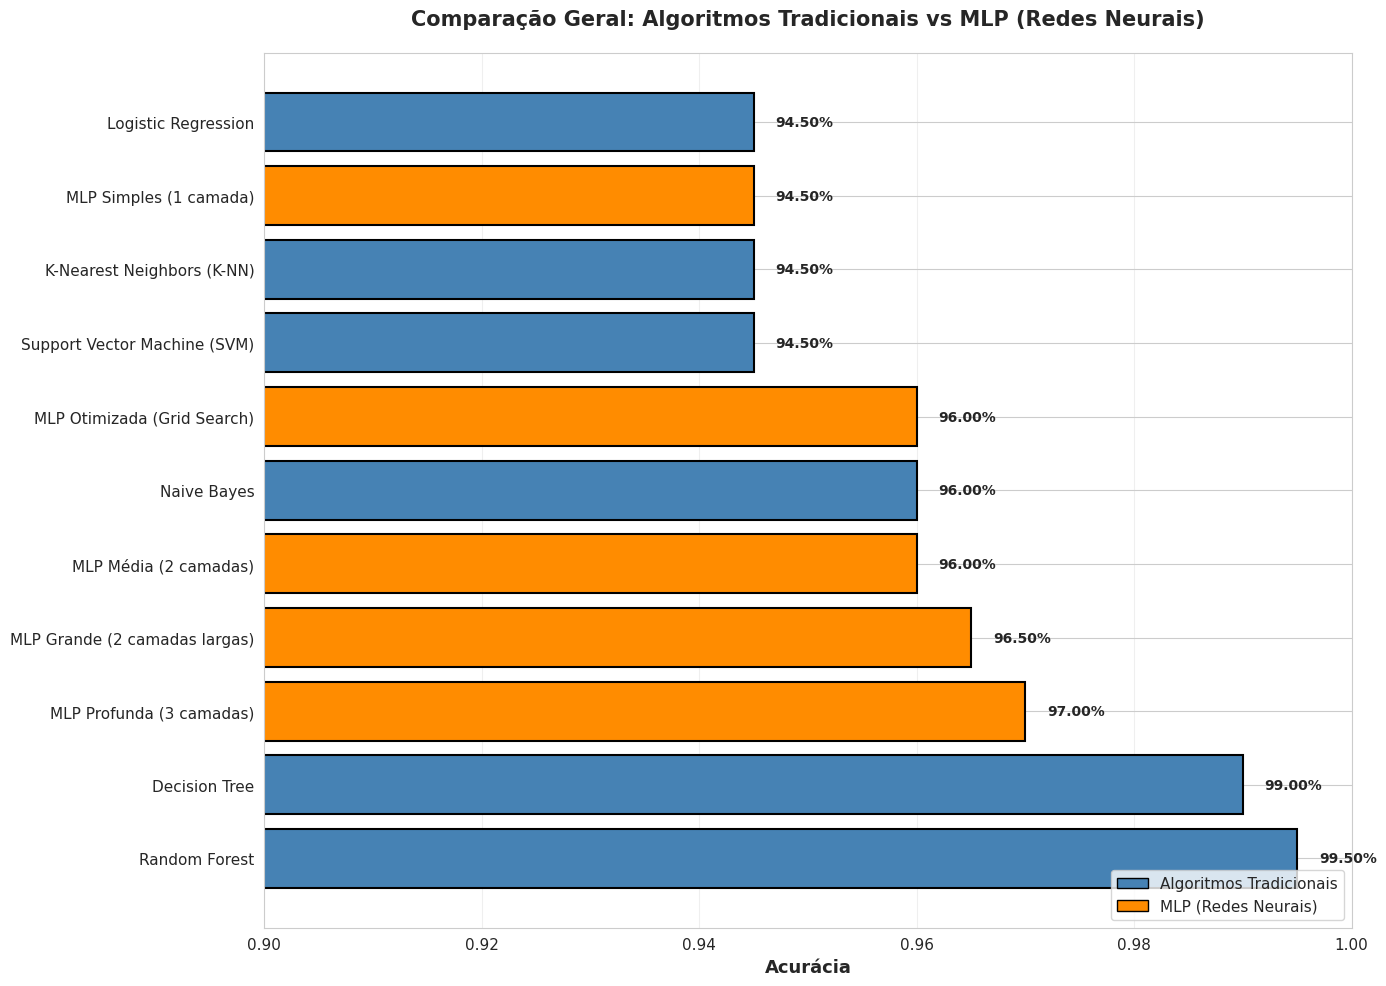

✓ Gráfico salvo: 01_comparacao_geral_todos_algoritmos.png


In [86]:
# Visualização 1: Comparação Geral
print("📈 Gerando visualizações...\n")

fig, ax = plt.subplots(figsize=(14, 10))

# Cores diferentes por tipo
colors = []
for tipo in comparison_df['Tipo']:
    if tipo == 'Tradicional':
        colors.append('steelblue')
    else:
        colors.append('darkorange')

y_pos = range(len(comparison_df))
bars = ax.barh(y_pos, comparison_df['Acurácia'], color=colors, edgecolor='black', linewidth=1.5)

ax.set_yticks(y_pos)
ax.set_yticklabels(comparison_df['Algoritmo'])
ax.set_xlabel('Acurácia', fontsize=13, fontweight='bold')
ax.set_title('Comparação Geral: Algoritmos Tradicionais vs MLP (Redes Neurais)', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xlim([0.9, 1.0])
ax.grid(True, alpha=0.3, axis='x')

# Adicionar valores
for i, (idx, row) in enumerate(comparison_df.iterrows()):
    ax.text(row['Acurácia'] + 0.002, i, f"{row['Acurácia']:.2%}", 
            va='center', fontsize=10, fontweight='bold')

# Legenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', edgecolor='black', label='Algoritmos Tradicionais'),
    Patch(facecolor='darkorange', edgecolor='black', label='MLP (Redes Neurais)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/01_comparacao_geral_todos_algoritmos.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico salvo: 01_comparacao_geral_todos_algoritmos.png")

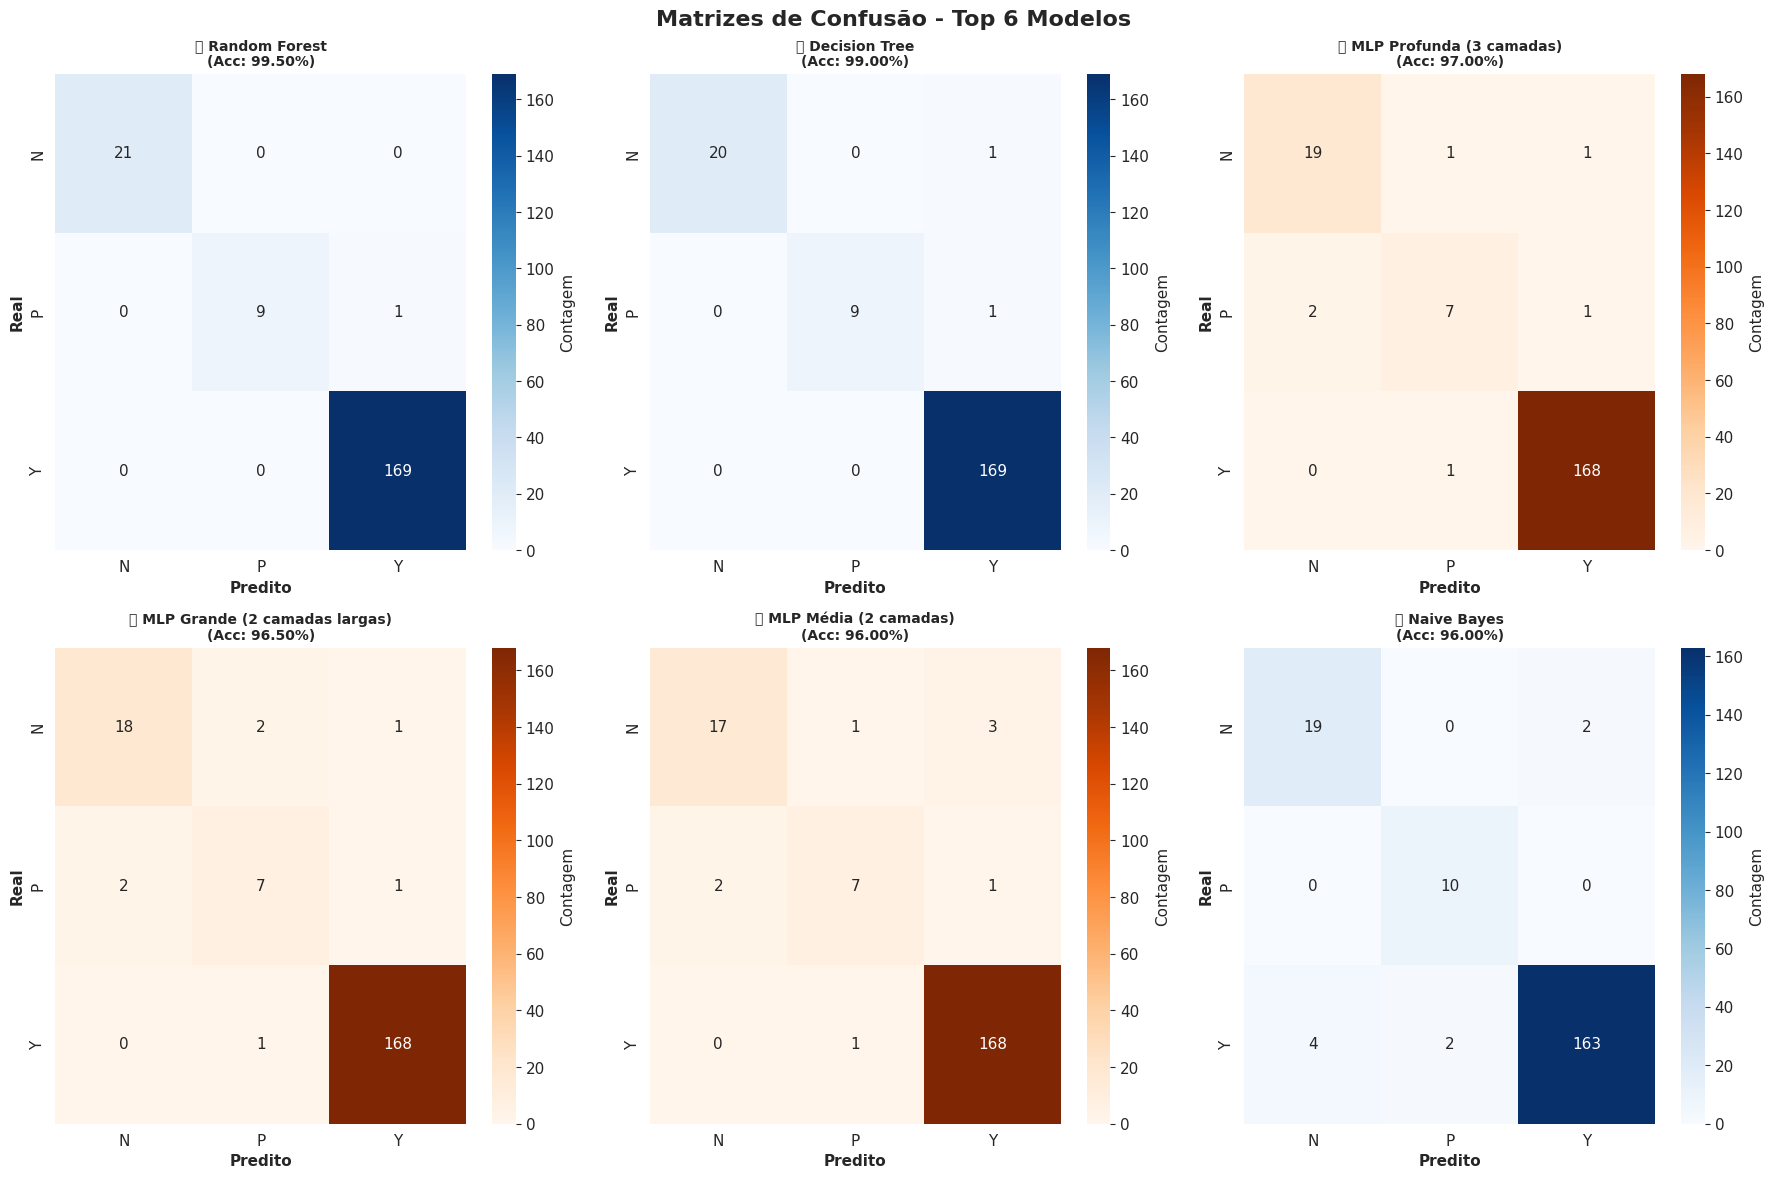

✓ Gráfico salvo: 02_matrizes_confusao_top6.png


In [87]:
# Visualização 2: Matrizes de Confusão - Top 6
top_6 = comparison_df.head(6)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Matrizes de Confusão - Top 6 Modelos', fontsize=16, fontweight='bold')

for idx, (_, row) in enumerate(top_6.iterrows()):
    r = idx // 3
    c = idx % 3
    
    name = row['Algoritmo']
    result = results[name]
    cm = result['confusion_matrix']
    classes = sorted(y_test.unique())
    
    # Cor baseada no tipo
    cmap = 'Blues' if result['type'] == 'Tradicional' else 'Oranges'
    
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=classes, yticklabels=classes,
                ax=axes[r, c], cbar_kws={'label': 'Contagem'})
    
    tipo_emoji = '🌳' if result['type'] == 'Tradicional' else '🧠'
    axes[r, c].set_title(f"{tipo_emoji} {name}\n(Acc: {result['accuracy']:.2%})", 
                        fontweight='bold', fontsize=10)
    axes[r, c].set_xlabel('Predito', fontweight='bold')
    axes[r, c].set_ylabel('Real', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/02_matrizes_confusao_top6.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico salvo: 02_matrizes_confusao_top6.png")

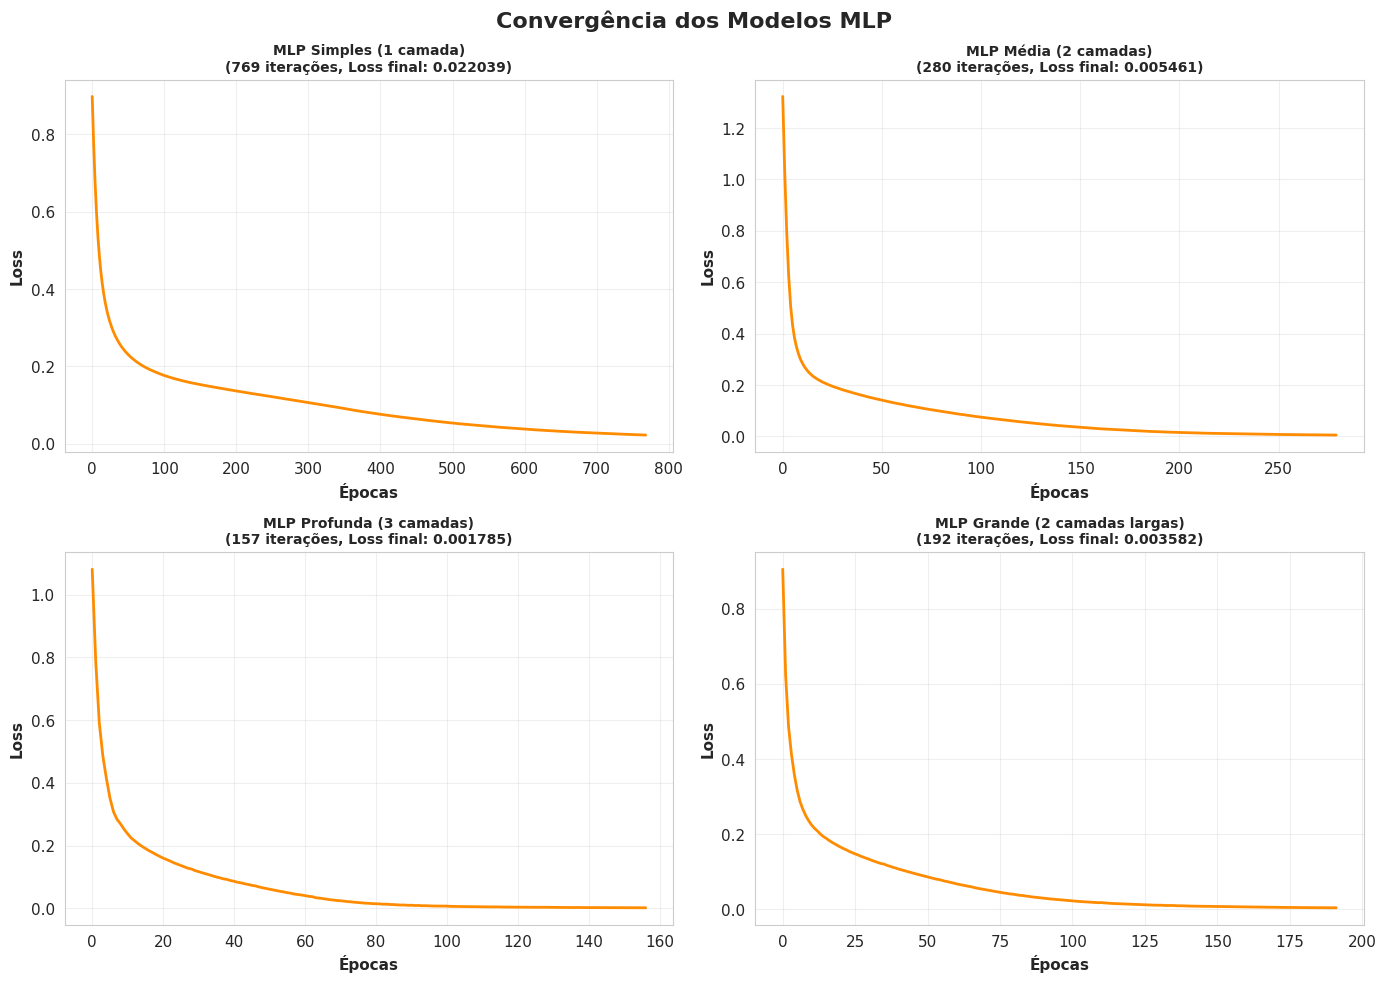

✓ Gráfico salvo: 03_convergencia_mlps.png


In [88]:
# Visualização 3: Convergência das MLPs
mlp_models = [(name, res) for name, res in results.items() 
              if res['type'] == 'MLP' and 'best_params' not in res]

if len(mlp_models) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Convergência dos Modelos MLP', fontsize=16, fontweight='bold')
    
    for idx, (name, result) in enumerate(mlp_models[:4]):
        r = idx // 2
        c = idx % 2
        
        model = result['model']
        if hasattr(model, 'loss_curve_'):
            axes[r, c].plot(model.loss_curve_, 'darkorange', linewidth=2)
            axes[r, c].set_xlabel('Épocas', fontweight='bold')
            axes[r, c].set_ylabel('Loss', fontweight='bold')
            axes[r, c].set_title(f'{name}\n({result["iterations"]} iterações, Loss final: {result["loss"]:.6f})', 
                               fontsize=10, fontweight='bold')
            axes[r, c].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/03_convergencia_mlps.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Gráfico salvo: 03_convergencia_mlps.png")

---
## 📤 11. Upload para MinIO (se disponível)

In [89]:
if MINIO_CONNECTED:
    print("📤 UPLOAD DE ARQUIVOS PARA MINIO\n")
    
    # Listar arquivos no diretório de outputs
    files = [f for f in os.listdir(OUTPUT_DIR) if os.path.isfile(os.path.join(OUTPUT_DIR, f))]
    
    print(f"Enviando {len(files)} arquivos para MinIO...\n")
    
    for file in files:
        file_path = os.path.join(OUTPUT_DIR, file)
        object_name = f"analysis/{datetime.now().strftime('%Y%m%d')}/{file}"
        
        try:
            minio_client.fput_object(
                MINIO_BUCKET,
                object_name,
                file_path
            )
            print(f"  ✓ {file} → {object_name}")
        except S3Error as e:
            print(f"  ✗ Erro ao enviar {file}: {e}")
    
    print(f"\n✓ Upload concluído! Arquivos disponíveis no bucket '{MINIO_BUCKET}'")
else:
    print("⚠️  MinIO não conectado. Arquivos salvos apenas localmente.")

📤 UPLOAD DE ARQUIVOS PARA MINIO

Enviando 6 arquivos para MinIO...

  ✓ 03_convergencia_mlps.png → analysis/20251202/03_convergencia_mlps.png
  ✓ resumo_completo_analise.txt → analysis/20251202/resumo_completo_analise.txt
  ✓ 01_comparacao_geral_todos_algoritmos.png → analysis/20251202/01_comparacao_geral_todos_algoritmos.png
  ✓ comparacao_completa_todos_algoritmos.csv → analysis/20251202/comparacao_completa_todos_algoritmos.csv
  ✓ 02_matrizes_confusao_top6.png → analysis/20251202/02_matrizes_confusao_top6.png
  ✓ 00_distribuicao_classes.png → analysis/20251202/00_distribuicao_classes.png

✓ Upload concluído! Arquivos disponíveis no bucket 'diabetes-analysis'


---
## 📋 12. Relatório Final Detalhado

In [90]:
print("="*100)
print("📋 RELATÓRIO FINAL DETALHADO")
print("="*100)

print(f"\n🏆 MELHOR MODELO TRADICIONAL: {best_traditional[0]}")
print(f"   Acurácia: {best_traditional[1]['accuracy']*100:.2f}%\n")
print("📊 Relatório de Classificação:")
print(classification_report(y_test, best_traditional[1]['predictions'], zero_division=0))

print("\n" + "="*100)
print(f"🧠 MELHOR MODELO MLP: {best_mlp[0]}")
print(f"   Acurácia: {best_mlp[1]['accuracy']*100:.2f}%")
if 'iterations' in best_mlp[1]:
    print(f"   Iterações: {best_mlp[1]['iterations']}")
    print(f"   Loss final: {best_mlp[1]['loss']:.6f}")
print("\n📊 Relatório de Classificação:")
print(classification_report(y_test, best_mlp[1]['predictions'], zero_division=0))

print("\n" + "="*100)
print("📊 COMPARAÇÃO: MELHOR TRADICIONAL vs MELHOR MLP")
print("="*100)

diff_pct = abs((best_traditional[1]['accuracy'] - best_mlp[1]['accuracy']) * 100)
if best_traditional[1]['accuracy'] > best_mlp[1]['accuracy']:
    print(f"\n✓ Algoritmo tradicional ({best_traditional[0]}) foi {diff_pct:.2f}% superior")
    print(f"  Para este dataset tabular, algoritmos tradicionais são mais eficientes.")
else:
    print(f"\n✓ MLP ({best_mlp[0]}) foi {diff_pct:.2f}% superior")
    print(f"  Redes neurais capturaram padrões complexos eficientemente.")

print("\n" + "="*100)
print("💡 RECOMENDAÇÕES")
print("="*100)
print(f"\n1. Use {best_overall[0]} para máxima acurácia ({best_overall[1]['accuracy']*100:.2f}%)")
print(f"2. Algoritmos tradicionais são mais simples e rápidos de treinar")
print(f"3. MLPs são úteis para dados complexos ou não estruturados (imagens, texto)")
print(f"4. Para datasets tabulares pequenos/médios, algoritmos tradicionais são suficientes")

print("\n" + "="*100)

📋 RELATÓRIO FINAL DETALHADO

🏆 MELHOR MODELO TRADICIONAL: Random Forest
   Acurácia: 99.50%

📊 Relatório de Classificação:
              precision    recall  f1-score   support

           N       1.00      1.00      1.00        21
           P       1.00      0.90      0.95        10
           Y       0.99      1.00      1.00       169

    accuracy                           0.99       200
   macro avg       1.00      0.97      0.98       200
weighted avg       1.00      0.99      0.99       200


🧠 MELHOR MODELO MLP: MLP Profunda (3 camadas)
   Acurácia: 97.00%
   Iterações: 157
   Loss final: 0.001785

📊 Relatório de Classificação:
              precision    recall  f1-score   support

           N       0.90      0.90      0.90        21
           P       0.78      0.70      0.74        10
           Y       0.99      0.99      0.99       169

    accuracy                           0.97       200
   macro avg       0.89      0.87      0.88       200
weighted avg       0.97      0

---
## 📄 13. Salvar Resumo em Arquivo

In [91]:
# Salvar resumo completo
with open(f'{OUTPUT_DIR}/resumo_completo_analise.txt', 'w', encoding='utf-8') as f:
    f.write("="*100 + "\n")
    f.write("ANÁLISE COMPARATIVA: ALGORITMOS TRADICIONAIS vs MLP (REDES NEURAIS)\n")
    f.write("="*100 + "\n\n")
    
    f.write(f"Dataset: {df.shape[0]} registros, {X.shape[1]} features\n")
    f.write(f"Data Source: {DATA_SOURCE}\n")
    f.write(f"Treino: {X_train.shape[0]} | Teste: {X_test.shape[0]}\n\n")
    
    f.write("RANKING GERAL:\n")
    f.write("-" * 100 + "\n")
    for idx, (_, row) in enumerate(comparison_df.iterrows(), 1):
        f.write(f"{idx}. {row['Algoritmo']:40s} ({row['Tipo']:12s}) - {row['Percentual']}\n")
    
    f.write("\n" + "="*100 + "\n")
    f.write(f"CAMPEÃO GERAL: {best_overall[0]}\n")
    f.write(f"ACURÁCIA: {best_overall[1]['accuracy']*100:.2f}%\n")
    f.write("="*100 + "\n")
    
    f.write("\n" + "="*100 + "\n")
    f.write("COMPARAÇÃO: MELHOR TRADICIONAL vs MELHOR MLP\n")
    f.write("="*100 + "\n")
    f.write(f"\nMelhor Tradicional: {best_traditional[0]}\n")
    f.write(f"Acurácia: {best_traditional[1]['accuracy']*100:.2f}%\n")
    f.write(f"\nMelhor MLP: {best_mlp[0]}\n")
    f.write(f"Acurácia: {best_mlp[1]['accuracy']*100:.2f}%\n")
    
    diff = (best_traditional[1]['accuracy'] - best_mlp[1]['accuracy']) * 100
    if diff > 0:
        f.write(f"\nDiferença: Tradicional é {diff:.2f}% melhor\n")
    else:
        f.write(f"\nDiferença: MLP é {-diff:.2f}% melhor\n")
    
    f.write("\n" + "="*100 + "\n")
    f.write("CONEXÕES:\n")
    f.write("="*100 + "\n")
    f.write(f"\nMLflow: {'Conectado ✓' if MLFLOW_CONNECTED else 'Não conectado ✗'}\n")
    f.write(f"MinIO: {'Conectado ✓' if MINIO_CONNECTED else 'Não conectado ✗'}\n")
    f.write(f"PostgreSQL: {'Conectado ✓' if DATA_SOURCE == 'PostgreSQL' else 'Não conectado ✗'}\n")

print("✓ Resumo salvo: resumo_completo_analise.txt")

✓ Resumo salvo: resumo_completo_analise.txt


---
## ✅ 14. Conclusão

### Análise completa concluída com sucesso! 🎉

**Foram testados:**
- ✅ 6 algoritmos tradicionais de Machine Learning
- ✅ 5 arquiteturas de Redes Neurais MLP
- ✅ Otimização com Grid Search
- ✅ Total: 11 modelos comparados

**Integrações:**
- 📊 MLflow para tracking de experimentos
- 📦 MinIO para armazenamento de artefatos
- 🗄️ PostgreSQL para dados (com fallback CSV)

**Arquivos gerados:**
- Gráficos comparativos
- Matrizes de confusão
- Tabelas de métricas
- Relatórios detalhados

---

### 🚀 Próximos passos sugeridos:
1. Testar com validação cruzada k-fold
2. Aplicar SMOTE para balancear classes minoritárias
3. Testar ensemble de modelos
4. Implementar feature engineering
5. Deploy do melhor modelo em produção